In [81]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Load in the Horizon AGN simulations

In [10]:
file_agn = 'Hz-AGN_powerspec.out'
file_no_agn = 'Hz-noAGN_powerspec.out'
file_dm = 'Hz-DM_powerspec.out'

In [152]:
def read_file(file_in,z_index=0):
    with open(file_in,"r") as infile:
        for l,line in enumerate(infile):
            if l==0:
                continue
            if l>1:
                break
            z = float((line.split()[1].split(','))[z_index+1].split('=')[1])
    k,cal_pk = np.loadtxt(file_in,usecols=[0,z_index+1],unpack=True)
    pk = (2.*np.pi**2.)*cal_pk/(k**3.)
    return z,k,pk

In [227]:
z_index = 0
z_agn,k_agn,pk_agn = read_file(file_agn,z_index)
z_no_agn,k_no_agn,pk_no_agn = read_file(file_no_agn,z_index)
z_dm,k_dm,pk_dm = read_file(file_dm,z_index)

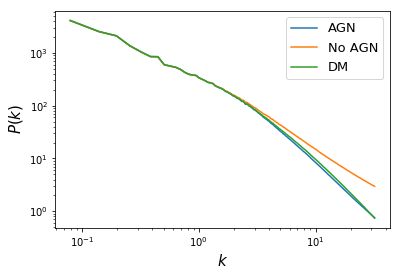

In [228]:
plt.loglog(k_agn,pk_agn,label='AGN')
plt.plot(k_no_agn,pk_no_agn,label='No AGN')
plt.plot(k_dm,pk_dm,label='DM')
plt.legend(fontsize=13);
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$P(k)$',fontsize=15);

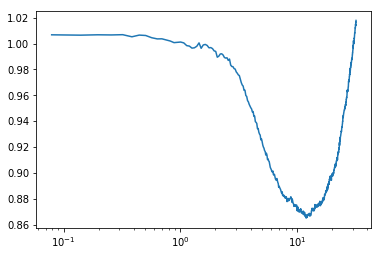

In [229]:
plt.semilogx(k_dm,pk_agn/pk_dm)

### Load in cosmological parameters

In [172]:
cosmo_params = {'Omega_cdm':(0.272-0.045),"Omega_b":0.045,"Omega_Lambda":0.728,"sigma8":0.81,"h":0.704,"n_s":0.967}

In [173]:
import sys
sys.path.append('/home/ophilcox/EffectiveHalos')
from EffectiveHalos import *

#### Run for DM sim

In [326]:
### fitted result of mead+15
odelta=300.#*cosm.cosmo.Omega_m()**(-0.352)

In [392]:
cosm = Cosmology(z_dm,npoints=10000,**cosmo_params)
mf = MassFunction(cosm,'Sheth-Tormen')#Tinker')#Bhattacharya')
hp = HaloPhysics(cosm,mf,'Duffy','NFW',npoints=1000,halo_overdensity='virial')

In [393]:
kk = k_dm[2:]
halop = HaloModel(cosm,mf,hp,kk)

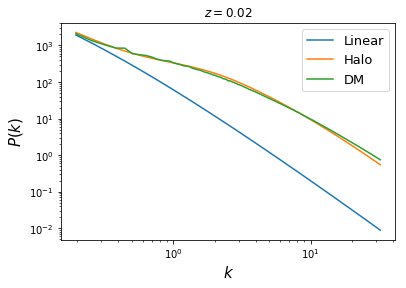

In [394]:
plt.loglog(kk,cosm.compute_linear_power(kk),label='Linear')
plt.loglog(kk,halop.halo_model(-1,-1,'Linear',0,0,0),label='Halo')
plt.plot(kk,pk_dm[2:],label='DM')
plt.legend(fontsize=13);
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$P(k)$',fontsize=15);
plt.title(r'$z = %.2f$'%z_dm);

In [395]:
k = k_dm[2:]
Pk_obs = pk_dm[2:]
L_box = 100.
from scipy.optimize import minimize
from scipy.interpolate import interp1d

In [396]:
def SHM(pars):
    return halop.halo_model(pars[0],pars[1],'Linear',0,0,0)
def EHM(pars):
    return halop.halo_model(pars[0],pars[1])
def one_halo(pars):
    return halop.I_20

In [397]:
model = {'SHM':SHM,'EHM':EHM,'One Halo':one_halo}
names = model.keys()

In [398]:
cols = ['red','blue','green','purple','orange','cyan','green']
k_fit = 1
n_fit = np.where(k<k_fit)[0][-1]

print('Fitting up to %.2f'%k[n_fit])

#nbody_mean = all_Pk.mean(axis=0)
#nbody_std = all_Pk.std(axis=0)/np.sqrt(len(all_Pk))

# Define covariance parameters
dk = np.mean(np.diff(k))
survey_vol = L_box**3.
N_modes = k**2.*dk*survey_vol/(2.*np.pi**2.)

def fit_model(model):
    def chi2(par):
        pred = model(par)[:n_fit]
        cov_Pk_diag = pred**2.*2./N_modes[:n_fit]
        prec_diag = 1./cov_Pk_diag
        prec = np.diag(prec_diag)
        diff = pred - Pk_obs[:n_fit]#nbody_mean[:n_fit]
        chi2val = np.matmul(diff.T,np.matmul(prec,diff))
        return chi2val
    x = minimize(chi2,[1.,1.])
    return x.x

fit_pars = []
for n,name in enumerate(names):
    fit_par = fit_model(model[name])
    fit_pars.append(fit_par)

Fitting up to 0.94


('Model: "EHM", parameters: ', array([7.42463867, 2.16403998]))
('Model: "SHM", parameters: ', array([1., 1.]))
('Model: "One Halo", parameters: ', array([1., 1.]))


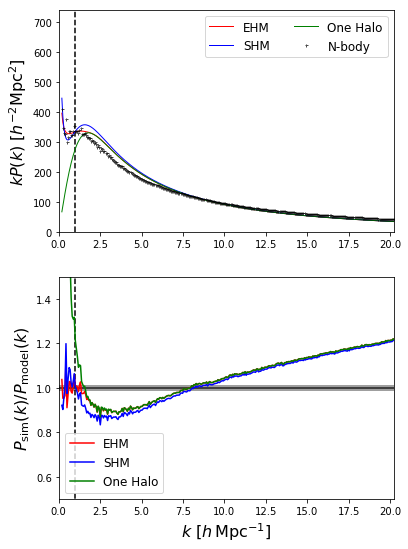

In [399]:
fig,ax = plt.subplots(2,1,figsize=(6,9))
ax[0].errorbar(k,k*Pk_obs,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
for n,name in enumerate(names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    alp = 1.
    lw = 1
    ax[0].plot(k,k*pred,label=name,alpha=alp,c=cols[n],lw=lw)
ax[0].legend(fontsize=12,ncol=2)
ax[0].set_ylim([0.,740])
ax[0].vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax[0].set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
#ax[0].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[0].set_xlim([0.01,20.2]);
#ax[0].set_xscale('log')

for n,name in enumerate(names):
    fit_par = fit_pars[n]
    pred = model[name](fit_par)
    ax[1].errorbar(k,Pk_obs/pred,label=name,alpha=alp,c=cols[n])
ax[1].set_ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{model}(k)$',fontsize=16)
ax[1].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[1].hlines(1.,0.001,100.,color='k',alpha=1)
ax[1].hlines([0.99,1.01],0.001,100.,color='k',alpha=0.5)
ax[1].vlines(k_fit,0,2,color='k',alpha=1.,linestyles='--')
ax[1].set_ylim([0.5,1.5])
#ax[1].set_xscale('log')
ax[1].legend(fontsize=12,ncol=1)
ax[1].set_xlim([0.01,20.2]);

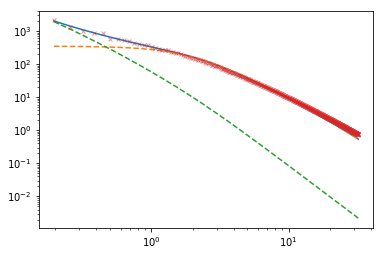

In [400]:
plt.loglog(k,EHM(fit_pars[0]))
plt.loglog(k,halop.I_20,ls='--')
plt.loglog(k,halop.I_11**2.*cosm.compute_linear_power(k),ls='--')
plt.errorbar(k,Pk_obs,marker='x',ls='',ms=4,alpha=0.5);

#### Try to fit DM-only sims